# Workshop on CIFAR10

Today you will be working on CIFAR10 on your own

Good luck

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import sys,time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#change this five times to get 5 cross validation
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


## 1. ETL : Load the MNIST

In [4]:
#use datasets.CIFAR to get train and test
#then split train to train and val in the percentage of 80:20
transform = transforms.ToTensor()
train_data = datasets.CIFAR10(root="../data/",train=True,download=True,transform= transform)
test_set  = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_data), len(test_set)

(50000, 10000)

In [6]:
train_set,val_set = torch.utils.data.random_split(train_data,[40000,10000])
len(train_set), len(val_set)

(40000, 10000)

## 2. EDA

2

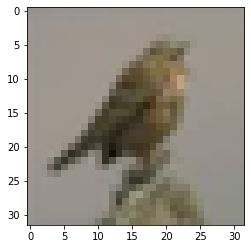

In [10]:
#Task 1: Please print one sample image of the training set
#permute from C,W,H ==> W,H,C beacuse imshow wants this shape
image = torch.permute(train_set[0][0],(1,2,0))
image.shape

plt.imshow(image) 
train_set[0][1]

In [12]:
#Task 2: check how many labels we have
train_data.targets #is provided by torch dataset format
set(train_data.targets)
# you can len()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [61]:
#Task 3: for each label, print one sample image
# for number in set(train_data.targets):
#     for image,target in train_data:
#         if number == target:
#             plt.figure()
#             image = torch.permute(train_set[number][0],(1,2,0))
#             plt.title(number)
#             plt.imshow(image)
#             break

In [63]:
#Task 3: for each label, print one sample image
indices = []
labels = []
for index, label in enumerate(train_data.targets):
    if len(indices) < 10:
        if label not in labels:
            labels.append(label)
            indices.append(index)
            
labels, indices

([6, 9, 4, 1, 2, 7, 8, 3, 5, 0], [0, 1, 3, 4, 6, 7, 8, 9, 27, 29])

In [68]:
sorted_indices = [ label for _, label in sorted(zip(labels, indices)) ]
sorted_indices

[29, 4, 6, 9, 3, 27, 0, 7, 8, 1]

Labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


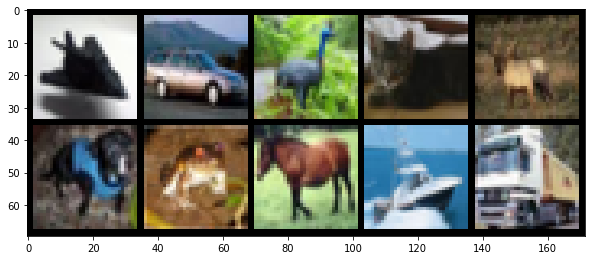

In [69]:
images = []
for i,image_index in enumerate(sorted_indices): #O[1]
    image = train_data[image_index][0]
    images.append(image)

image_tensor = torch.stack(images,0) #make_grind(tensor)
image_tensor.shape #tensor shape: B, C, W, H #(10, 3, 32, 32)

print("Labels:", torch.arange(10))

grid_image = make_grid(image_tensor, nrow=5)  # the default nrow is 8
grid_image = torch.permute(grid_image, (1, 2, 0))
plt.figure(figsize=(10,8))
plt.imshow(grid_image)

## 3. Create dataloader for train, val, test

In [76]:
batch_size = 100

#format Dataloader(dataset,batch_size, shuffle)
train_loader = DataLoader(train_set, batch_size = batch_size,    shuffle=True, pin_memory=True, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size = batch_size,  shuffle=True, pin_memory=True, num_workers=2) #batch_size = len(val_set)
test_loader  = DataLoader(test_set,  batch_size = batch_size, shuffle=True, pin_memory=True, num_workers=2) #batch_size = len(test_set)

### 3.1 Test to the dataloader

In [78]:
for image,label in train_loader:
    print(image.shape) #what is the shape (100,3,32,32) == (batch_size, C, W, H)
    print(label.shape) #what is the shape (100)
    break

image = torch.randn((100,3,32,32))

torch.Size([100, 3, 32, 32])
torch.Size([100])


## 4. Test your knowledge on conv2d

In [94]:
image.shape

torch.Size([100, 3, 32, 32])

In [105]:
#create two layers of conv2d
#from 3 -> 256 -> 128
#image shape: (B,3,32,32)
#format: nn.Conv2d(input_channel, output_channel, kernel_size, stride = 1,padding=0)
#outsize = (input_size - kernel_size +2padding )/stride + 1
layer1 = nn.Conv2d(3, 256, 3, 1, 0) 
out = layer1(image)
print(out.shape)
#out_size = (32 - 3) / 1 + 1
#after layer 1: shape (B,256,30,30)
layer2 = nn.Conv2d(256, 128, 3, 1, 0)
out = layer2(out)
print(out.shape)
#out_size = (30 - 3) / 1 + 1
#after layer 2: shape (B,128,28,28)

#don't forget to reshape[B,128,28,28] ==> (B,128*28*28)
out = out.reshape(-1,128*28*28) #linear layer can only take 2 layers

#follow by two linear layer 128 -> 20 -> 10
layer3 = nn.Linear(128*28*28,20)
out = layer3(out)
print(out.shape)
#after layer 3: shape (B,20)
layer4 = nn.Linear(20,10)
out = layer4(out)
print(out.shape)
#after layer 4: shape (B,10)

# layers = nn.Sequential(layer1,layer2,layer3,layer4)

torch.Size([100, 256, 30, 30])
torch.Size([100, 128, 28, 28])
torch.Size([100, 20])
torch.Size([100, 10])


## 5. Desing the neural network

In [115]:
class cifarCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #conv2d(3,256) -> relu -> batchnorm -> conv2d(256,128) -> relu -> batchnorm ->
        self.layer1 = nn.Conv2d(3, 256, 3, 1, 0) 
        self.norm1 = nn.BatchNorm2d(256)
        self.maxpool = nn.MaxPool2d(2,2)

        self.layer2 = nn.Conv2d(256, 128, 3, 1, 0)
        self.norm2 = nn.BatchNorm2d(128)
        
        #linear(128,64) -> relu -> linear(64,20) -> relu -> linear(20,10)
        self.linear1 = nn.Linear(128*6*6, 64)
        self.linear2 = nn.Linear(64, 20)
        self.linear3 = nn.Linear(20, 10)
    
    def forward(self,image):
        out = self.maxpool(self.relu(self.layer1(image)))
        #out_size = 15
        out = self.maxpool(self.relu(self.layer2(out)))
        #(15 - 3) / 1 + 1 = 13 
        #out_size = 6 (After maxpool)
        out = out.reshape(-1, 128*6*6)
        out = self.relu(self.linear1(out))
        out = self.relu(self.linear2(out))
        return self.linear3(out)

## 6. Test the model

In [117]:
#creat the model, out them into the device
model = cifarCNN().to(device)
#let's use (B,C,W,H)
image.shape
#try input this image to the model
out = model(image)
#check the output size
out.shape #[100, 10] = [Batch_size, output_size]

torch.Size([100, 10])

## 7. Count the parameters

In [119]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)
#whht is 6912 ? conv2d weight 3*256*3*3
#what is 256 ? conv2d bias 128 come from the bias of the frist conv2d layers
#256 gamma of batchnorm
#256 lambda of batchnorms

  6912
   256
   256
   256
294912
   128
   128
   128
6422528
    64
  1280
    20
   200
    10
______
6727078


## 8. Training!!!

In [124]:
#define loss
criterion = nn.CrossEntropyLoss()
#define optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

train_accs = []
val_corr = []
val_old_loss = float("inf")
filepath = '../models/cifacnn.pt'
epochs = 5
for e in range(epochs): #for epoch 5
    total_train_corr = 0
    for batch, (image,label) in enumerate(train_loader):  #for trainloader
        image.to(device) #put image and label to device
        label.to(device)

        yhat = model(image) #1.predict
        loss = criterion(yhat,label) #2.loss

        #add accuracy
        predicted = torch.max(yhat,1)[1]
        bacth_train_corr = (predicted == label).sum()
        total_train_corr += bacth_train_corr
        train_acc = (total_train_corr * 100) / (batch_size * (batch + 1))
        train_accs.append(train_acc)

        optimizer.zero_grad() #3.clear gradient
        loss.backward() #4.backpropagate
        optimizer.step() #5.update

        #print the loss
        if (batch+1) % 100 == 1:
            sys.stdout.write(f'/rBatch: {batch+1} - Loss: {loss}')
            print(f'Epoch : {e}; Batch Step : {batch:3.0f} Train loss : {loss:.2f} Acc : {train_acc:.2f}')

    #after each epoch , calculate the validation acc and loss
    with torch.no_grad():
        total_val_corr = 0
        for (val_image,val_label) in val_loader:
            val_image.to(device) #put image and label to device
            val_label.to(device)
            val_yhat = model(val_image)
            val_loss = criterion(val_yhat,val_label)
            #save the model with the lowest loss
            if val_loss < val_old_loss:
                torch.save(model.state_dict(), filepath) #state_dict is simple the weights
            val_predicted = torch.max(val_yhat, 1)[1]
            total_val_corr += (val_predicted == val_label).sum()
        val_acc = (val_corr * 100) / len(val_set)
        print(f'++++++Validation++++++ : Val_loss : {val_loss:.2f} - Acc: {val_acc:.2f}')

Epoch : 0; Batch Step ;    1 Train loss : 2.30
Epoch : 0; Batch Step ;  201 Train loss : 2.30
Epoch : 1; Batch Step ;    1 Train loss : 2.30
Epoch : 1; Batch Step ;  201 Train loss : 2.31
Epoch : 2; Batch Step ;    1 Train loss : 2.30
Epoch : 2; Batch Step ;  201 Train loss : 2.31
Epoch : 3; Batch Step ;    1 Train loss : 2.30
Epoch : 3; Batch Step ;  201 Train loss : 2.30
Epoch : 4; Batch Step ;    1 Train loss : 2.30
Epoch : 4; Batch Step ;  201 Train loss : 2.30


## 9. Plot the loss and acc

In [ ]:
train_losses = [loss.item() for loss in train_losses]
train_accs   = [acc.item()  for acc  in train_accs]
val_losses   = [loss.item() for loss in val_losses]
val_accs     = [acc.item()  for acc  in val_accs]

In [ ]:
plt.plot(train_losses, label='training loss')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

In [ ]:
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

In [ ]:
plt.plot(train_accs, label='training acc')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

In [ ]:
plt.plot(val_accs, label='validation loss')
plt.legend()
plt.title('Loss/acc at the end of each epoch')

## 10. Check which image we got wrong ..... with confusion matrix 
- even print out the image we predict wrong.....

In [ ]:
# Display the confusion matrix as a heatmap
import seaborn as sns

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

## 11. Testing!!!

In [ ]:
#do by yourself
#load the best model based on val loss
model = cifarCNN().to(device)
# model.load_state_dict(torch.load(filepath)) #load the best model

#do the testing phase! :-)
with torch.no_grad():
    test_corr = 0 
    for test_image, test_label in test_loader:
        test_image = test_image.to(device)
        test_label = test_label.to(device)
        test_yhat = model(test_image)
        test_loss = criterion(test_yhat, test_label)
        test_predicted = torch.max(test_yhat, 1)[1]
        test_corr += (test_predicted == test_label).sum()
    test_acc = (test_corr * 100) / len(test_set)
    
print(test_acc)